In [1]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, MixedDataLoader

####

from pathlib import Path
from typing import Tuple, Dict, Any, Callable
from itertools import combinations
from datetime import datetime

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [2]:
class RBM(nn.Module):
    num_visible: int
    num_hidden: int
    k: int = 1
    T: float = 1.0

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.num_visible, self.num_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.num_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.num_hidden,))

    def __call__(self, data: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, self.c, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (aux_vars["gibbs_chain"], aux_vars["key"]))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)

        free_energy_data = jnp.mean(self._free_energy(data))
        free_energy_model = jnp.mean(self._free_energy(gibbs_chain))

        regularization = aux_vars["l2_strength"] * (jnp.sum(self.W**2) + jnp.sum(self.b**2) + jnp.sum(self.c**2))
        loss = free_energy_data - free_energy_model + regularization

        aux_vars = {
            "gibbs_chain": gibbs_chain,
            "key": key,
            "free_energy_data": free_energy_data,
            "free_energy_model": free_energy_model,
        }

        return loss, aux_vars

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(v @ self.W + self.c), -1)

    @nn.nowrap
    def free_energy(self, v: jnp.ndarray) -> jnp.ndarray:
        return self._free_energy(v)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    @nn.nowrap
    def generate(self, num_samples: int, T_schedule: jnp.ndarray, key: PRNGKey) -> jnp.ndarray:
        key, key_init = jax.random.split(key, 2)
        v = jax.random.bernoulli(key_init, p=0.5, shape=(num_samples, self.num_visible)).astype(jnp.float32)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, (v, key))
        return v_final

In [3]:
@jax.jit
def train_step(state: TrainState, batch: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:

    key, key_reset = jax.random.split(aux_vars["key"])
    aux_vars["key"] = key

    # reset gibbs_chain[i] with batch[i] given reset probability as chain_reset_frac
    reset_mask = jax.random.bernoulli(key_reset, p=aux_vars["chain_reset_frac"], shape=(batch.shape[0], 1))
    aux_vars["gibbs_chain"] = jnp.where(reset_mask, batch, aux_vars["gibbs_chain"])

    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars


def count_modes(chain: jnp.ndarray) -> int:
    chain = chain.astype(jnp.uint32)
    powers = 2 ** jnp.arange(chain.shape[-1], dtype=jnp.uint32)
    ints = jnp.dot(chain, powers)

    hist = jnp.bincount(ints, length=1 << chain.shape[-1])
    return int(jnp.sum(hist > 0))


def train(
        state: TrainState,
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey,
        chain_reset_frac: float,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float]) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    gibbs_chain = None

    for epoch in range(num_epochs):
        tot_loss = 0.0

        for i, batch in enumerate(loader):
            measurements = batch[:, :, 0].astype(jnp.float32)

            if gibbs_chain is None:
                gibbs_chain = measurements

            key, subkey = jax.random.split(key)
            aux_vars = {
                "gibbs_chain": gibbs_chain,
                "key": subkey,
                "chain_reset_frac": chain_reset_frac,
                "l2_strength": l2_strength,
            }

            state, loss, aux_vars = train_step(state, measurements, aux_vars)
            gibbs_chain = aux_vars["gibbs_chain"]
            key = aux_vars["key"]
            free_energy_model = aux_vars["free_energy_model"]
            free_energy_data  = aux_vars["free_energy_data"]

            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        modes = count_modes(gibbs_chain)
        lr = lr_schedule_fn(state.step)

        metrics[epoch] = dict(
            loss=avg_loss,
            modes=modes,
            free_energy_model=free_energy_model,
            free_energy_data=free_energy_data,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Modes: {modes} │ "
              f"Free En. Model: {free_energy_model:.4f} │ "
              f"Free En. Data: {free_energy_data:.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [4]:
file_path = Path("data/tfim_h1.00_3x3_10000.txt")
data = load_measurements(file_path)

measurements = data[:, :, 0]
empirical_freq = measurements.mean(axis=0)
empirical_freq

Parsing measurements: 100%|██████████| 10000/10000 [00:00<00:00, 23112.40it/s]


Array([0.49679998, 0.4982    , 0.49589998, 0.4978    , 0.49679998,
       0.496     , 0.49899998, 0.4974    , 0.4983    ], dtype=float32)

In [5]:
batch_size   = 1024             # larger requires more epochs for the model to go down in its modes
num_visible  = 9
hidden_units = 9               # interesting, lower gives evener frequencies, although the modes go not down to 1
k_steps      = 50               # more steps required if small batch size
num_epochs   = 500             # longer since large batch size
init_lr      = 1e-2             # large drives modes down fast but learns nothing, to small and we dont get any one hots
final_lr     = init_lr * 0.1
chain_reset_frac = 0.1
l2_strength  = 1e-4

# we chose 16 in the hope that our conditioner has more to work with

# runs also very nicely if l2 norm is turned off completely but the free energies get large

key_seed = PRNGKey(42)
key, key_params, key_dummy = jax.random.split(key_seed, 3)

model = RBM(num_visible=num_visible, num_hidden=hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, num_visible), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, num_visible), dtype=jnp.float32), "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size, drop_last=True) # we need the last batch to match the chain dimension

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optimizer = optax.adam(lr_schedule_fn)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optimizer)

state, metrics = train(state, loader, num_epochs, key, chain_reset_frac, l2_strength, lr_schedule_fn)

Epoch 1/500 │ Loss: +0.0022 │ Modes: 441 │ Free En. Model: -5.8231 │ Free En. Data: -5.8245 │ Learning Rate: 0.00779
Epoch 2/500 │ Loss: +0.0044 │ Modes: 435 │ Free En. Model: -5.3739 │ Free En. Data: -5.3623 │ Learning Rate: 0.00778
Epoch 3/500 │ Loss: -0.0564 │ Modes: 431 │ Free En. Model: -5.1607 │ Free En. Data: -5.2942 │ Learning Rate: 0.00777
Epoch 4/500 │ Loss: -0.2716 │ Modes: 444 │ Free En. Model: -5.1772 │ Free En. Data: -5.5853 │ Learning Rate: 0.00776
Epoch 5/500 │ Loss: -0.6169 │ Modes: 442 │ Free En. Model: -5.3896 │ Free En. Data: -6.1695 │ Learning Rate: 0.00776
Epoch 6/500 │ Loss: -0.9862 │ Modes: 425 │ Free En. Model: -5.2552 │ Free En. Data: -6.3828 │ Learning Rate: 0.00775
Epoch 7/500 │ Loss: -1.3497 │ Modes: 426 │ Free En. Model: -4.8142 │ Free En. Data: -6.3343 │ Learning Rate: 0.00774
Epoch 8/500 │ Loss: -1.6770 │ Modes: 412 │ Free En. Model: -4.4864 │ Free En. Data: -6.3251 │ Learning Rate: 0.00773
Epoch 9/500 │ Loss: -1.9788 │ Modes: 413 │ Free En. Model: -4.38

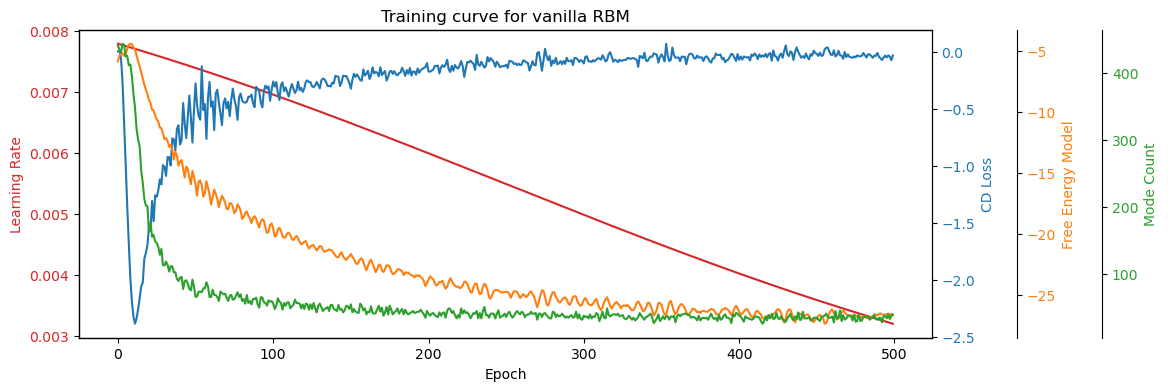

In [6]:
epochs = list(metrics.keys())

loss_vals = [metrics[e]['loss'] for e in epochs]
mode_vals = [metrics[e]['modes'] for e in epochs]
free_energy_model_vals = [metrics[e]['free_energy_model'] for e in epochs]
free_energy_data_vals = [metrics[e]['free_energy_data'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.set_xlabel("Epoch")

ax1.plot(epochs, lr_vals, color="tab:red")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.plot(epochs, loss_vals, color="tab:blue")
ax2.set_ylabel("CD Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")
ax2.spines["right"].set_position(("axes", 1.0))

ax3 = ax1.twinx()
ax3.plot(epochs, free_energy_model_vals, color="tab:orange")
ax3.set_ylabel("Free Energy Model", color="tab:orange")
ax3.tick_params(axis="y", labelcolor="tab:orange")
ax3.spines["right"].set_position(("axes", 1.1))

ax4 = ax1.twinx()
ax4.plot(epochs, mode_vals, color="tab:green")
ax4.set_ylabel("Mode Count", color="tab:green")
ax4.tick_params(axis="y", labelcolor="tab:green")
ax4.spines["right"].set_position(("axes", 1.2))

plt.title("Training curve for vanilla RBM")
plt.show()

In [7]:
# constant tempeature schedule is important for TFIM data
sampling_steps = 1000
constant_schedule = jnp.full((sampling_steps,), 1.0, dtype=jnp.float32)

T_high = 2.0
T_low = 0.01
sampling_steps = 5_000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

key_sample = PRNGKey(1234)

samples = model.apply(
    {"params": state.params},
    num_samples=10_000,
    T_schedule=constant_schedule,
    key=key_sample,
    method=RBM.generate
)

sampled_freq = samples.mean(0)
sampled_freq

Array([0.5244    , 0.5251    , 0.52639997, 0.5276    , 0.5221    ,
       0.5234    , 0.5255    , 0.5227    , 0.5232    ], dtype=float32)

In [8]:
def magnetization_z(samples: jnp.ndarray) -> jnp.ndarray: # (num_samples, num_qubits)
    # making sure it is not unsigned when changing to -1 and +1 domain
    samples = samples.astype(jnp.float32)  # ensure float for division
    spins = 1 - 2 * samples  # map 0 -> +1, 1 -> -1
    sample_magnetisations = jnp.abs(spins.mean(axis=1)) # the .abs gives us the spontaneous magnetization
    total_magnetisation = sample_magnetisations.mean()
    return total_magnetisation  # mean over samples, gives us the global magnetization

mag_z = magnetization_z(measurements)
mag_z

Array(0.96788895, dtype=float32)

In [9]:
# now the same for the sampled data
mag_z_sampled = magnetization_z(samples)
mag_z_sampled

Array(0.96195567, dtype=float32)

In [10]:
import flax

def amplitude_ratio_flip(
        model: RBM,
        params: flax.core.FrozenDict,
        sample: jnp.ndarray,         # shape (batch_size, num_visible)
        flip_idx: int
) -> jnp.ndarray:
    # flip that one bit
    sample_flipped = sample.at[:, flip_idx].set(1 - sample[:, flip_idx])

    # compute F(v) and F(v') via apply+method
    F_ref  = model.apply({"params": params}, sample,        method=RBM.free_energy)
    F_flip = model.apply({"params": params}, sample_flipped, method=RBM.free_energy)

    # amplitude ratio = exp[(F(v) - F(v'))/2]
    return jnp.exp((F_ref - F_flip) / 2)


def magnetization_x(
        model: RBM,
        params: flax.core.FrozenDict,
        samples: jnp.ndarray          # shape (batch_size, num_visible)
) -> jnp.ndarray:
    # for each qubit index i, get a vector of ratios shape (batch,)
    flip_fn = lambda i: amplitude_ratio_flip(model, params, samples, i)
    # vmap over the spin index axis → (num_visible, batch_size)
    qubit_ratios = jax.vmap(flip_fn)(jnp.arange(samples.shape[1]))
    # average over qubits *and* batch:
    return qubit_ratios.mean()


mag_x = magnetization_x(model, state.params, samples)
mag_x

Array(0.2708021, dtype=float32)

In [ ]:
plt.show()
timestamp = datetime.now().strftime("%Y%m%d%H%M")
model_name = f"rbm_amp_{timestamp}"

checkpoints.save_checkpoint(
    ckpt_dir=str(model_dir.resolve()),
    target=state.params,
    step=0,
    prefix=model_name + "_",
    overwrite=True
)